# Tutorial: Basic Example with Simulated Data

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/imperial-college/trace/blob/main/docs/tutorials/01_basic_example.ipynb)

This tutorial demonstrates the complete **TRACE** workflow using synthetically generated data. We cover data simulation, model fitting, diagnostics, posterior predictive checks, and forecasting.

## Installation

If running in Colab, install TRACE:

In [1]:
# Uncomment if running in Colab
# !pip install git+https://github.com/ojwatson/trace.git

## Import Libraries

In [2]:
import sys
sys.path.insert(0, '../../src')  # For local development

import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from trace.simulate import simulate_conflict_data
from trace.analysis import run_inference, posterior_predictive, forecast
from trace.analysis import plot_fit, plot_forecast

# Set random seed
np.random.seed(42)

## 1. Data Simulation

We begin by specifying the "true" parameters and generating synthetic data:

In [3]:
# True model parameters
TRUE_PARAMS = {
    "mu_w_true": 5.0,      # Average wounded per event
    "mu_i_true": 2.0,      # Average immediate deaths per event  
    "p_late_true": 0.20,   # Hospital fatality rate (20%)
    "ell_true": 20.0,      # Spatial length scale (degrees)
}

# Delay distribution (from injury to death)
delay_probs = np.array([0.5, 0.3, 0.15, 0.05])

print("True Parameters:")
for key, val in TRUE_PARAMS.items():
    print(f"  {key}: {val}")

True Parameters:
  mu_w_true: 5.0
  mu_i_true: 2.0
  p_late_true: 0.2
  ell_true: 20.0


### Generate Synthetic Data

In [4]:
sim_data = simulate_conflict_data(
    n_regions=3,
    n_hospitals=5,
    T=90,
    mu_w_true=TRUE_PARAMS["mu_w_true"],
    mu_i_true=TRUE_PARAMS["mu_i_true"],
    p_late_true=TRUE_PARAMS["p_late_true"],
    delay_probs=delay_probs,
    ell_true=TRUE_PARAMS["ell_true"],
    events_rate=2.0,
    seed=42
)

print(f"\nSimulated {len(sim_data['events'])} conflict events")
print(f"Total injuries: {sim_data['hospital_incidence'].sum():.0f}")
print(f"Total deaths: {sim_data['national_deaths'].sum():.0f}")


Simulated 169 conflict events
Total injuries: 836
Total deaths: 483


### Visualize Simulated Data

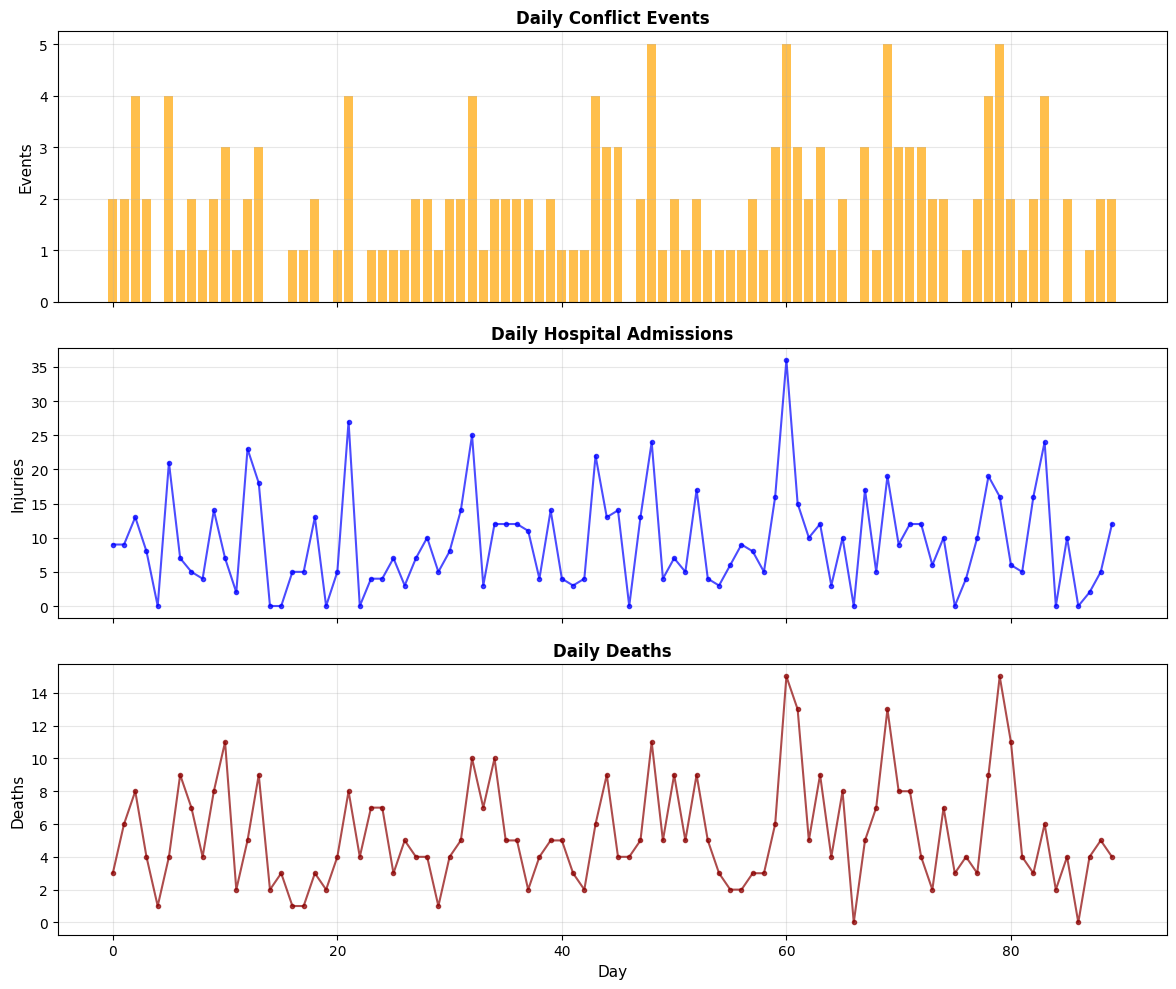

In [5]:
fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

# Daily events
events_per_day = np.bincount([e['date'] for e in sim_data['events']], minlength=90)
axes[0].bar(range(90), events_per_day, color='orange', alpha=0.7)
axes[0].set_ylabel('Events', fontsize=11)
axes[0].set_title('Daily Conflict Events', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Hospital injuries
total_injuries = sim_data['hospital_incidence'].sum(axis=1)
axes[1].plot(range(90), total_injuries, 'o-', color='blue', alpha=0.7, markersize=3)
axes[1].set_ylabel('Injuries', fontsize=11)
axes[1].set_title('Daily Hospital Admissions', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)

# Deaths
axes[2].plot(range(90), sim_data['national_deaths'], 'o-', color='darkred', alpha=0.7, markersize=3)
axes[2].set_ylabel('Deaths', fontsize=11)
axes[2].set_xlabel('Day', fontsize=11)
axes[2].set_title('Daily Deaths', fontsize=12, fontweight='bold')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 2. Prepare Data for Modeling

In [6]:
# Event information
events_by_day = np.zeros(90)
event_days = []
event_coords = []

for event in sim_data['events']:
    day = event['date']
    events_by_day[day] += 1
    event_days.append(day)
    event_coords.append([event['latitude'], event['longitude']])

event_days = np.array(event_days)
event_coords = np.array(event_coords)

# Hospital and death data
hospital_coords = sim_data['hospital_coords']
injuries_obs = sim_data['hospital_incidence']
deaths_obs = sim_data['national_deaths']

print(f"Prepared data for {len(event_days)} events over {len(events_by_day)} days")
print(f"Number of hospitals: {hospital_coords.shape[0]}")

Prepared data for 169 events over 90 days
Number of hospitals: 5


## 3. Model Fitting with MCMC

Fit the Bayesian model using MCMC with the NUTS sampler:

In [7]:
print("Running MCMC inference (this may take a few minutes)...\n")

mcmc, samples = run_inference(
    events_by_day=events_by_day,
    event_day_index=event_days,
    event_coords=event_coords,
    hospital_coords=hospital_coords,
    injuries_obs=injuries_obs,
    deaths_obs=deaths_obs,
    delay_probs=delay_probs,
    num_warmup=1000,
    num_samples=2000,
    num_chains=2,
    rng_seed=42
)

Running MCMC inference (this may take a few minutes)...



sample: 100%|██████████| 3000/3000 [00:03<00:00, 927.82it/s, 3 steps of size 3.58e-01. acc. prob=0.95]  



                mean       std    median      5.0%     95.0%     n_eff     r_hat
       ell     18.84      0.87     18.81     17.43     20.24   2764.27      1.00
      mu_i      1.49      0.23      1.50      1.11      1.87   1611.75      1.00
      mu_w      4.94      0.17      4.94      4.65      5.21   3204.35      1.00
    p_late      0.28      0.05      0.27      0.20      0.35   1679.83      1.00

Number of divergences: 0


### Parameter Recovery

Compare posterior estimates to true values:

In [15]:
print("\n" + "="*60)
print("Parameter Recovery: Estimated vs True Values")
print("="*60)

params = ['mu_w', 'mu_i', 'p_late', 'ell']
true_vals = [
    TRUE_PARAMS['mu_w_true'],
    TRUE_PARAMS['mu_i_true'],
    TRUE_PARAMS['p_late_true'],
    TRUE_PARAMS['ell_true']
]

for param, true_val in zip(params, true_vals):
    est = samples[param].mean()
    ci_low = np.percentile(samples[param], 2.5)
    ci_high = np.percentile(samples[param], 97.5)
    print(f"{param:8s}: {est:.3f} (95% CI: [{ci_low:.3f}, {ci_high:.3f}])  True: {true_val:.3f}")


Parameter Recovery: Estimated vs True Values
mu_w    : 4.943 (95% CI: [4.609, 5.287])  True: 5.000
mu_i    : 1.491 (95% CI: [1.014, 1.921])  True: 2.000
p_late  : 0.277 (95% CI: [0.194, 0.375])  True: 0.200
ell     : 18.842 (95% CI: [17.229, 20.622])  True: 20.000


In [16]:
samples

{'ell': Array([18.51622 , 18.743435, 18.41343 , ..., 20.67629 , 19.740803,
        19.53592 ], dtype=float32),
 'mu_i': Array([1.48434  , 1.5474674, 1.5547805, ..., 1.578316 , 1.9155833,
        1.7576299], dtype=float32),
 'mu_w': Array([4.974957 , 5.015768 , 4.799225 , ..., 4.774626 , 5.0377254,
        5.034482 ], dtype=float32),
 'p_late': Array([0.31139043, 0.28347778, 0.26887852, ..., 0.24549496, 0.19958483,
        0.19899397], dtype=float32)}

## 4. Posterior Predictive Checks

In [17]:
print("\nGenerating posterior predictive samples...")

preds = posterior_predictive(
    samples=samples,
    events_by_day=events_by_day,
    event_day_index=event_days,
    event_coords=event_coords,
    hospital_coords=hospital_coords,
    injuries_obs_shape=injuries_obs.shape,
    deaths_obs_shape=len(deaths_obs),
    delay_probs=delay_probs,
    rng_seed=1
)

print(f"Generated {preds['obs_deaths'].shape[0]} posterior predictive samples")


Generating posterior predictive samples...
Generated 4000 posterior predictive samples


### Visualize Model Fit

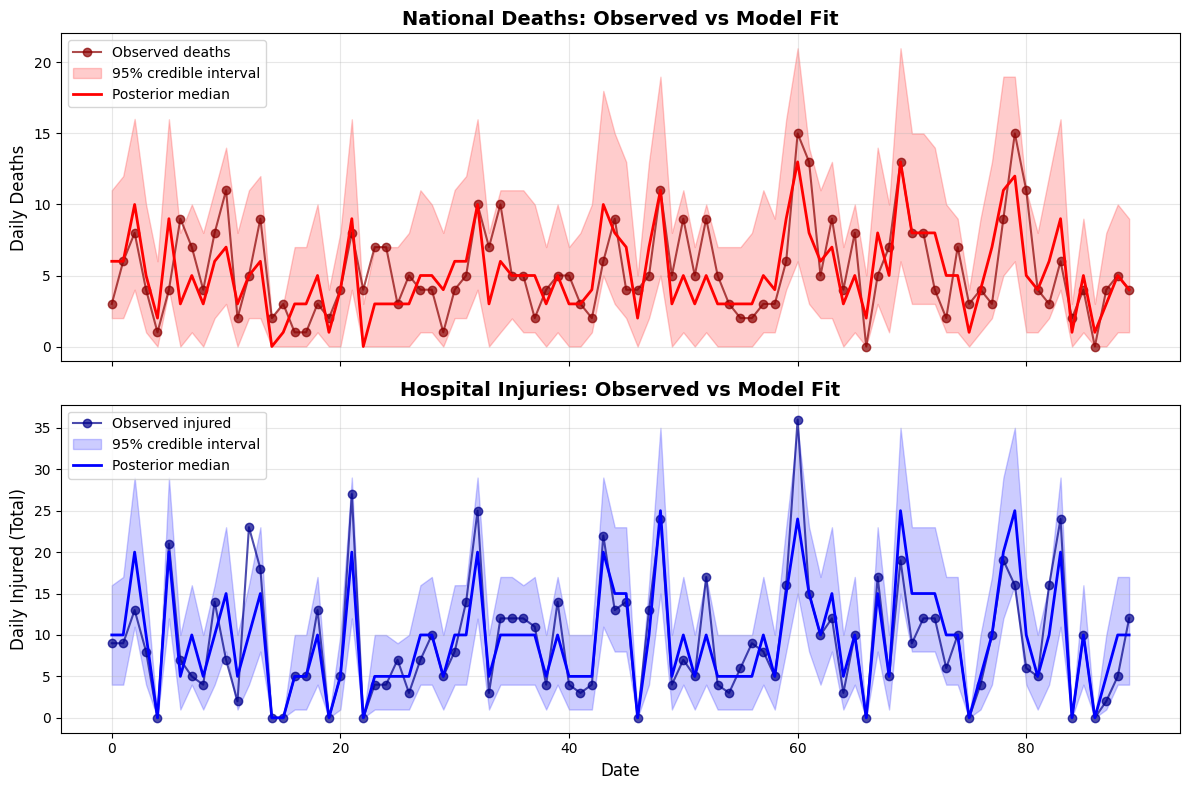

In [10]:
dates = np.arange(90)

fig = plot_fit(
    dates=dates,
    injuries_obs=injuries_obs,
    deaths_obs=deaths_obs,
    preds=preds
)
plt.show()

### Quantitative Checks

In [18]:
# Coverage probability for deaths
deaths_lower = np.percentile(preds['obs_deaths'], 2.5, axis=0)
deaths_upper = np.percentile(preds['obs_deaths'], 97.5, axis=0)
coverage = np.mean((deaths_obs >= deaths_lower) & (deaths_obs <= deaths_upper))

print(f"\nPosterior Predictive Check:")
print(f"Death observations within 95% CI: {coverage*100:.1f}%")

# Mean absolute error
pred_median = np.median(preds['obs_deaths'], axis=0)
mae = np.mean(np.abs(deaths_obs - pred_median))
print(f"Median absolute error: {mae:.2f} deaths/day")


Posterior Predictive Check:
Death observations within 95% CI: 97.8%
Median absolute error: 1.91 deaths/day


## 5. Forecasting

### Baseline Scenario

In [19]:
# Estimate recent event rate
recent_rate = events_by_day[-30:].mean()
print(f"Recent event rate: {recent_rate:.2f} events/day")

# 30-day forecast
future_events = np.full(30, recent_rate)

forecast_results = forecast(
    samples=samples,
    future_events_by_day=future_events,
    delay_probs=delay_probs
)

print(f"\n30-day forecast total deaths: {forecast_results['deaths_median'].sum():.0f}")

Recent event rate: 2.20 events/day

30-day forecast total deaths: 146


### Visualize Forecast

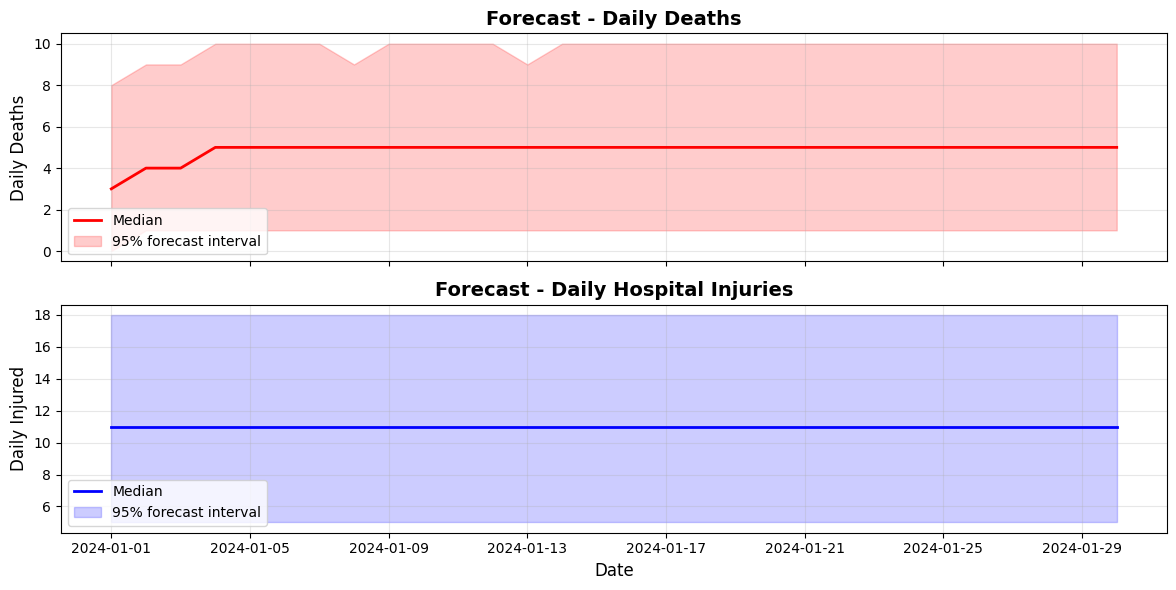

In [20]:
fig = plot_forecast(
    forecast_results=forecast_results,
    start_date=np.datetime64('2024-01-01')
)
plt.show()

### Scenario Comparison

In [21]:
scenarios = {
    'Baseline': np.full(30, recent_rate),
    'Ceasefire (90% reduction)': np.full(30, recent_rate * 0.1),
    'Escalation (2x events)': np.full(30, recent_rate * 2.0),
}

print("\n" + "="*60)
print("Scenario Analysis: 30-Day Forecasts")
print("="*60)

results = {}
for name, events in scenarios.items():
    forecast_res = forecast(samples, events, delay_probs)
    total_deaths = forecast_res['deaths_median'].sum()
    results[name] = total_deaths
    print(f"{name:30s}: {total_deaths:6.0f} deaths")

# Quantify impact
baseline = results['Baseline']
ceasefire = results['Ceasefire (90% reduction)']
lives_saved = baseline - ceasefire

print(f"\nLives saved by ceasefire: {lives_saved:.0f} ({lives_saved/baseline*100:.1f}% reduction)")


Scenario Analysis: 30-Day Forecasts
Baseline                      :    146 deaths
Ceasefire (90% reduction)     :      0 deaths
Escalation (2x events)        :    269 deaths

Lives saved by ceasefire: 146 (100.0% reduction)


## Summary

This tutorial demonstrated:

1. ✓ Simulating realistic conflict casualty data
2. ✓ Fitting a Bayesian model with MCMC
3. ✓ Diagnosing convergence and assessing fit
4. ✓ Posterior predictive checking
5. ✓ Scenario-based forecasting
6. ✓ Parameter recovery validation

**Key Takeaways**:

- Simulated data provides ground truth for validation
- MCMC diagnostics are essential (check R-hat and ESS)
- Posterior predictive checks reveal model adequacy
- Scenario analysis quantifies intervention impacts

**Next Steps**: See [Gaza Analysis Tutorial](02_gaza_analysis.ipynb) to apply these methods to real conflict data.